# Analysis of the State Farm image data

This notebook provides analysis of the provided State Farm data, using Theano and Keras to build the NN


## Set up the environment
First, let's import what we need and set up environment variables, etc.

In [1]:
# Imports of the relevant libraries
import numpy as np
import cv2
import pandas as pd
import sys
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# These are the locations of the images provided by Kaggle
# Root Dir is needed for Python, but not for create lmdb shell script later... (we need it there too!)
image_root_dir = './imgs/'
train_image_source_dir = "./train"
test_image_source_dir = "./test"
driver_image_list = "./driver_imgs_list.csv"

# These are the locations of the images that we will work with 
# Note that as we're continually mix up training and validation drivers/images, 
# then we will store images in one directory and use code to determine whether to train or validate
train_images_dir = "./images/train/"
validation_images_dir = "./images/validate/" 
test_images_dir = "./images/test/"

## Process the list of training images
There are only 27 different drivers so in order to avoid overfitting, or testing using very similar data to training, we will split the data based on the driver into train and validation sets.

Initially though, let's get the list of drivers, see how many images are available for each driver, and which classification they have been labelled with.


In [2]:
driver_list = pd.read_csv(driver_image_list)
print driver_list.head()

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


Seperate the drivers into a training and validation set.  To ensure we don't have overfitting (the training set and the validation set contain the same or similar images) we will split on drivers, so a driver can only appear in training or validation but not both.


In [3]:
driver_ids = []
for id, driver in driver_list.iterrows():
    if driver['subject'] not in driver_ids:
        driver_ids.append(driver['subject'])
print "Found the following drivers: {}".format(driver_ids)
    

Found the following drivers: ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']


Split into train and validation data tests (split = percentage to have in training set)


In [7]:
def split_drivers_into_train_and_validate(driver_list, split = 0.75):
    driver_valid_list = []
    # Take a random sample of drivers into the training list
    driver_train_list = np.random.choice(driver_list, int(len(driver_list)*split), replace = False)
    # Take the remaining drivers into the validation list
    driver_valid_list = [ driver for driver in driver_list if driver not in driver_train_list]
    return driver_train_list, driver_valid_list
    
#X_train, X_test, y_train, y_test = train_test_split(X_all.ix[rows], student_data[target_col].ix[rows], test_size=test_size)

training_list, validation_list = split_drivers_into_train_and_validate(driver_ids)
print "Driver train list: {}".format(training_list)
print "Driver validation list: {}".format(validation_list)

Driver train list: ['p026' 'p039' 'p041' 'p002' 'p051' 'p014' 'p052' 'p064' 'p016' 'p061'
 'p024' 'p045' 'p015' 'p012' 'p042' 'p022' 'p021' 'p056' 'p047']
Driver validation list: ['p035', 'p049', 'p050', 'p066', 'p072', 'p075', 'p081']


Now we have a list of the drivers, their classification and their images, let's loads images one by one
and get the dimensions of the image (put this into the dataframe too!)

In [66]:
def render_image(image_filename):
    print "render_image(): Rendering {}".format(image_filename)
    image = cv2.imread(image_filename)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show() 
    #print image.shape
    #plt.imshow(image)
    
def split_image_data(driver_list, filter, render = True):
    """Split the data based on a filter (train, valid, test, etc.).  
    render is used if we want to see the first image only as a sample of the data"""
    image_list = []
    class_list = []
    class_count = dict()
    driver_count = dict()
    total = 0
    # for idx, driver in driver_list.iterrows():
    for driver_row in [ drvr for drvr in driver_list.iterrows() if drvr[1]['subject'] in filter ]:
        driver = driver_row[1]  # Drop the index created by the Pandas Dataframe
        #img_filename = train_image_source_dir + '/' + driver['classname'] + '/' + driver['img']
        driver_class = int(driver['classname'][1:])  # Get integer to represent class (eg 'c0' is class '0')
        #image_list.append(img_filename)
        image_list.append(driver['img'])
        class_list.append(driver_class)
        # Display the first image if render is set to True (by default we do this!)
        if render == True:
            render_image(image_root_dir + train_image_source_dir + '/' + driver['classname'] + '/' + driver['img'])
            render = False
        # Track how many images we get for each class
        if driver_class in class_count:
            class_count[driver_class] += 1
        else:
            class_count[driver_class] = 1
        # Track the number of drivers
        if driver['subject'] in driver_count:
            driver_count[driver['subject']] += 1
        else:
            driver_count[driver['subject']] = 1
        # Keep a running total and track progress
        total += 1
        if total % 100 == 0:
            print ".",
    # Print some useful stats   
    print 
    #print "Found the following numbers of images per class {}".format(class_count) 
    #print "Found the following numbers of images per driver {}".format(driver_count)
    print "Total number of images found {}".format(total)
    #Return a list of images and their classification
    return image_list, class_list

# From https://groups.google.com/forum/#!topic/caffe-users/SqYFtnNVNSU
# TODO - Not sure if this file is needed now we've moved from Caffe???
def write_image_file(location, image_list, class_list):
    filename = location + ".txt"
    print "write_image_file()/: Creating image and class list... {}".format(filename)
    f = open(filename, 'w')  # Create a txt file with the image location and class
    for i, c in zip(image_list, class_list):
        f.write(i + " " + str(c) + "\n")
    f.close()   


Identifying training images:
render_image(): Rendering ./imgs/./train/c0/img_44733.jpg


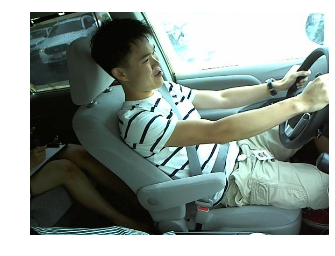

(480, 640, 3)
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Total number of images found 16758
write_image_file()/: Creating image and class list... ./images/train/.txt

Identifying validation images:
render_image(): Rendering ./imgs/./train/c0/img_66660.jpg


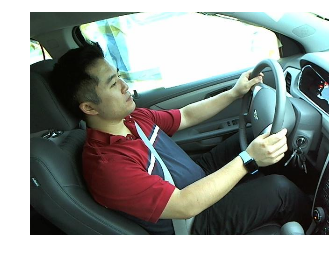

(480, 640, 3)
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Total number of images found 5666


NameError: name 'valid_images_dir' is not defined

In [12]:

print "\nIdentifying training images:"
train_image_list, train_class_list = split_image_data(driver_list, training_list)
write_image_file(train_images_dir, train_image_list, train_class_list)

print "\nIdentifying validation images:"
validation_image_list, validation_class_list = split_image_data(driver_list, validation_list)
write_image_file(valid_images_dir, validation_image_list, validation_class_list)


## Split images into the directories
This will make life easier for training and testing, but may take a while!!

In [50]:
import os

image_width = 160
image_height = 120
image_colour_dim = 1  # Go for greyscale. (1=greyscale, 3=colour)

def pre_process_image(image):
    if image_colour_dim == 1:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    processed_img = cv2.resize(image, (image_width, image_height)) 
    return processed_img
    
def create_image_repository(images_dest_dir, images_list, class_list):
    print "create_image_repository(): Creating images in {}".format(images_dest_dir)
    copied = 0 
    for f, c in zip(images_list, class_list):
        dest_dir = images_dest_dir + str(c) + "/"
        if os.path.exists(dest_dir) == False:
            !mkdir $dest_dir
        orig_img = cv2.imread(image_root_dir + train_image_source_dir + '/c' + str(c) + '/' + f)
        #if image_colour_dim == 1:
        #    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
        #resized_img = cv2.resize(orig_img, (image_width, image_height)) 
        processed_image = pre_process_image(orig_img)
        cv2.imwrite(images_dest_dir + str(c) + "/" + f, processed_image)
        copied += 1
        if copied % 100 == 0:
            print ".",
    print "Done!"
    return copied
    

In [14]:
# Start by clearing out any old data (ignore failures here if the directory doesn't exist)
# TODO - Move to Python code to be OS independent
!rm -rf $train_images_dir
!rm -rf $validation_images_dir
!rm -rf $test_images_dir

# Create directories
!mkdir -p $train_images_dir
!mkdir -p $validation_images_dir
!mkdir -p $test_images_dir

# Create training images folder with the correct images
num_training_samples = create_image_repository(train_images_dir, train_image_list, train_class_list)
num_validation_samples = create_image_repository(validation_images_dir, validation_image_list, validation_class_list)


create_image_repository(): Creating images in ./images/train/
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Done!
create_image_repository(): Creating images in ./images/validate/
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Done!


In [15]:
print "{} training images".format(num_training_samples)
print "{} validation images".format(num_validation_samples)

16758 training images
5666 validation images


## Create an inital CNN using Keras
Starting with no pre-loaded weights though as we'll train this with our own data.
Based on example here http://keras.io

TODO: In a future iteration, we'll play about with this architecture and the activation, optimizer and loss functions

In [16]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers import Dense, Flatten
model = Sequential()

# Now create the NN architecture (version 1)
# Going with colour for now!!
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, image_width, image_height)))
model.add(Convolution2D(16, 3, 3, border_mode='same'))
# As we had 2D data before, this will flatten it for the Dense NN which is 1D!! 
# https://github.com/fchollet/keras/issues/2724
model.add(Flatten())    
model.add(Dense(10, activation='relu'))

#Now compilte the model
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model.summary()

Using Theano backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 160, 120)  896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 16, 160, 120)  4624        convolution2d_1[0][0]            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 307200)        0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 10)            3072010     flatten_1[0][0]                  
Total params: 3077530
_____________________________________________________________________

#### TODO : Add in model.load_weights(filename) here at some point

## Training

Use the examples in the image pre-processing to train the model (from http://keras.io/preprocessing/image/)
'tf' means images are dimension 

In [21]:
from keras.preprocessing.image import ImageDataGenerator
# Take defaults for now
train_datagen = ImageDataGenerator()   
valid_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(train_images_dir, 
                                                    target_size=(image_width, image_height))
validation_generator = valid_datagen.flow_from_directory(validation_images_dir,
                                                   target_size=(image_width, image_height))


Found 16758 images belonging to 10 classes.
Found 5666 images belonging to 10 classes.


In [31]:
%%capture train_log
model.fit_generator(train_generator,
                    nb_epoch = 25,
                    samples_per_epoch=num_training_samples,
                    validation_data=validation_generator,
                    nb_val_samples=num_validation_samples)

In [32]:
model.save_weights('./model/saved_weights_1.h5')

In [33]:
print train_log.stdout

Epoch 1/25
16758/16758 [==============================] - 686s - loss: 0.1046 - acc: 0.1026 - val_loss: 0.1044 - val_acc: 0.1027
Epoch 2/25
16758/16758 [==============================] - 684s - loss: 0.1045 - acc: 0.1059 - val_loss: 0.1044 - val_acc: 0.1024
Epoch 3/25
16758/16758 [==============================] - 695s - loss: 0.1044 - acc: 0.1037 - val_loss: 0.1045 - val_acc: 0.1032
Epoch 4/25
16758/16758 [==============================] - 689s - loss: 0.1046 - acc: 0.1013 - val_loss: 0.1044 - val_acc: 0.1027
Epoch 5/25
16758/16758 [==============================] - 701s - loss: 0.1045 - acc: 0.1063 - val_loss: 0.1044 - val_acc: 0.1040
Epoch 6/25
16758/16758 [==============================] - 715s - loss: 0.1045 - acc: 0.0998 - val_loss: 0.1045 - val_acc: 0.1022
Epoch 7/25
16758/16758 [==============================] - 701s - loss: 0.1045 - acc: 0.1065 - val_loss: 0.1045 - val_acc: 0.1024
Epoch 8/25
16758/16758 [==============================] - 728s - loss: 0.1045 - acc: 0.1015 - val

In [34]:
print train_log.stderr

## Manual testing
Test an image manually to see if it gives an answer we can check by hand!

In [63]:
class_descriptions=['c0: safe driving',
    'c1: texting - right',
    'c2: talking on the phone - right',
    'c3: texting - left',
    'c4: talking on the phone - left',
    'c5: operating the radio',
    'c6: drinking',
    'c7: reaching behind',
    'c8: hair and makeup',
    'c9: talking to passenger']

render_image(): Rendering ./images/validate/0/img_32990.jpg


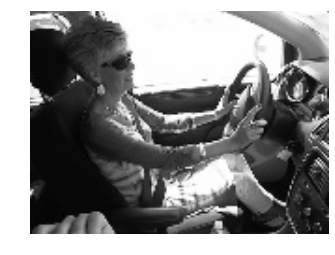

1/1 [==============================] - 0s
Image classified as c2: talking on the phone - right / actual = c0: safe driving
render_image(): Rendering ./images/validate/1/img_67880.jpg


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


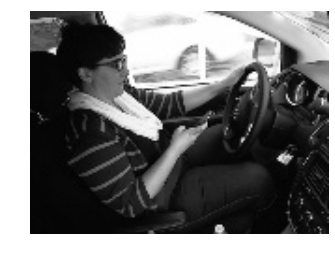

1/1 [==============================] - 0s
Image classified as c2: talking on the phone - right / actual = c1: texting - right
render_image(): Rendering ./images/validate/2/img_39676.jpg


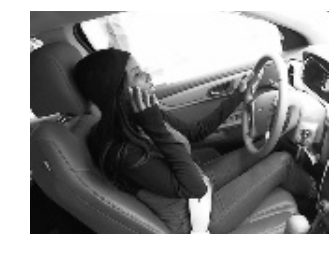

1/1 [==============================] - 0s
Image classified as c2: talking on the phone - right / actual = c2: talking on the phone - right
render_image(): Rendering ./images/validate/3/img_43894.jpg


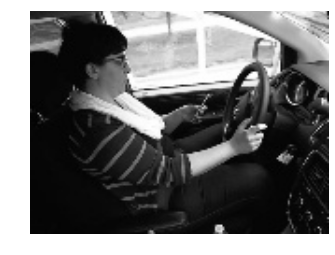

1/1 [==============================] - 0s
Image classified as c2: talking on the phone - right / actual = c3: texting - left
render_image(): Rendering ./images/validate/4/img_28927.jpg


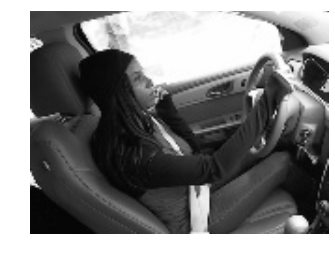

1/1 [==============================] - 0s
Image classified as c2: talking on the phone - right / actual = c4: talking on the phone - left
render_image(): Rendering ./images/validate/5/img_5690.jpg


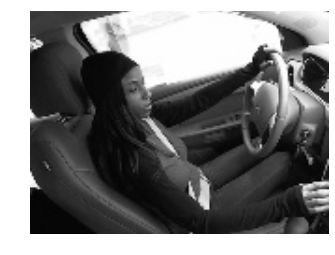

1/1 [==============================] - 0s
Image classified as c2: talking on the phone - right / actual = c5: operating the radio
render_image(): Rendering ./images/validate/6/img_23821.jpg


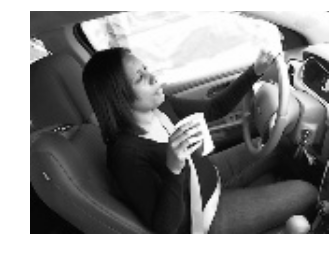

1/1 [==============================] - 0s
Image classified as c2: talking on the phone - right / actual = c6: drinking
render_image(): Rendering ./images/validate/7/img_6364.jpg


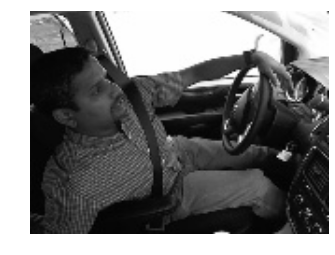

1/1 [==============================] - 0s
Image classified as c2: talking on the phone - right / actual = c7: reaching behind
render_image(): Rendering ./images/validate/8/img_100814.jpg


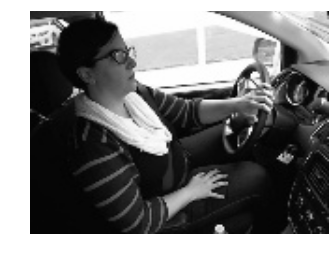

1/1 [==============================] - 0s
Image classified as c2: talking on the phone - right / actual = c8: hair and makeup


In [67]:
import random 
#test_image_path = "./images/validate/0/img_96916.jpg"
def classify_image(test_image_path):
    render_image(test_image_path)
    image=np.random.random((1, 3, image_width, image_height))
    image[0]=cv2.imread(test_image_path).transpose(2,1,0)
    classes = model.predict_classes(image)
    return classes

# Randomly select images from the validation set
for c in range(0,9):
    image_dir=validation_images_dir + str(c) + '/'
    image_list=os.listdir(image_dir)
    image_file = random.choice(image_list)
    classes = classify_image(image_dir + image_file)
    print "Image classified as {} / actual = {}".format(class_descriptions[classes], class_descriptions[c])
    


[2]
